In [25]:
import numpy as np
import pandas as pd
import pickle
import sys
import os
import torch
from sklearn.metrics import cohen_kappa_score
import matplotlib.pyplot as plt
import seaborn as sns

plt.rcParams.update({
    "font.family": "serif",  # use serif/main font for text elements
    "text.usetex": True,     # use inline math for ticks
    "pgf.rcfonts": False,
    "font.size": 14,
    "font.family": "Computer Modern Roman"
    })

module_path = os.path.abspath(os.path.join('..'))

if module_path not in sys.path:
    sys.path.append(module_path)
print(module_path)
from datasets import dataset_utils
from datasets import sequence_aggregator
from explainability_analysis.visualization_functions import * 
from explainability_analysis.transformer_analysis import *
from explainability_analysis.crop_spectral_signature_analysis import * 
from explainability_analysis.classification_results_summarizer import * 

num_classes = 12
max_sequence_length = 144

def sort_obs_acq_dates_by_attention(model_root_path):
    
    predictions_path = os.path.join(model_root_path, "predictions")
    predicted_vs_true_results = pd.read_csv(os.path.join(predictions_path, "predicted_vs_true.csv"))
    attn_weights_path = os.path.join(predictions_path, "attn_weights", "postprocessed")
    
    temporal_attn_weights = pd.read_csv(os.path.join(attn_weights_path, "parcel_temporal_attention.csv"))
    temporal_attn_weights["Date"] = pd.to_datetime(temporal_attn_weights["Date"])
    avg_attention_per_obs_acq_date = temporal_attn_weights.groupby("Date")["Attention"].mean()
    avg_attention_per_obs_acq_date = avg_attention_per_obs_acq_date.sort_values(ascending=False)
    
    return avg_attention_per_obs_acq_date


def get_most_important_dates_for_percentage_scores(percentages, perc_dates_results, avg_attention_per_obs_acq_date_orig_model):
    
    result_dfs = []
    for perc in percentages:
        num_top_n_perc_dates = round((perc / 100.0) * max_sequence_length)
        top_n_perc_dates = avg_attention_per_obs_acq_date_orig_model.iloc[0:num_top_n_perc_dates].reset_index()
        top_n_perc_dates["PERCENTAGE"] = int(perc)
        top_n_perc_dates["Date"] = pd.to_datetime(top_n_perc_dates["Date"]).apply(lambda date: date.strftime("%m-%d"))
        #top_n_perc_dates["DATE"] = top_n_perc_dates["DATE"].apply(lambda date: date[date.index("-") + 1:])
        top_n_perc_dates_with_accuracy = pd.merge(top_n_perc_dates, perc_dates_results, left_on="PERCENTAGE", right_on="Percent of observations")
        result_dfs.append(top_n_perc_dates_with_accuracy)
    
    return pd.concat(result_dfs, ignore_index=True).sort_values(by="Date")

C:\Users\Ivica Obadic\PycharmProjects\EOExplainability


In [4]:
dataset_folder = "C:/Users/datasets/BavarianCrops/"
model_root_path = "C:/Users/results/{}_classes/right_padding/obs_aq_date/layers=1,heads=1,emb_dim=128/all_dates/ts"
model_root_path = model_root_path.format(num_classes)

avg_attention_per_obs_acq_date_orig_model = sort_obs_acq_dates_by_attention(model_root_path)
avg_attention_per_obs_acq_date_orig_model.to_csv(os.path.join(model_root_path, "key_attention_dates.csv"))

In [5]:
avg_attention_per_obs_acq_date_orig_model

Date
2018-07-03    21.172584
2018-07-01    18.460557
2018-06-06     6.829939
2018-07-08     6.034199
2018-08-22     5.414222
                ...    
2018-01-09     0.020773
2018-02-18     0.020593
2018-02-13     0.020007
2018-02-01     0.018978
2018-01-29     0.016792
Name: Attention, Length: 144, dtype: float64

Text(0.5, 1.0, 'Classification accuracy for the top-N attention dates')

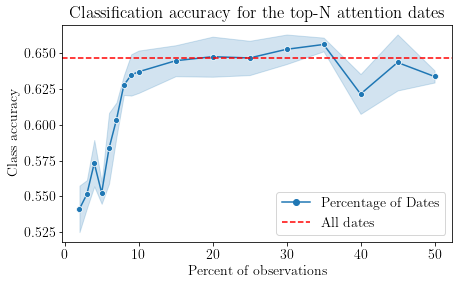

In [42]:
original_model_result = read_classification_results(model_root_path)
perc_dates_results = pd.read_csv(os.path.join(model_root_path, "perc_accuracy_results.csv"), index_col=0)

fig, axs = plt.subplots(figsize=(7, 4))
sns.lineplot(data=perc_dates_results, x="Percent of observations", y='Class accuracy', hue="Model type", style="Model type", ci="sd",ax=axs, markers=True, dashes=False)
axs.axhline(y=original_model_result[0], c='red', linestyle='dashed', label="All dates")
axs.legend(loc="best")
axs.set_title("Classification accuracy for the top-N attention dates")

C:\Users\anaconda3\lib\site-packages\pandas\core\reshape\merge.py:1214: UserWarning: You are merging on int and float columns where the float values are not equal to their int representation
  warnings.warn(


Text(0.5, 1.0, 'Overview of the top-N attention dates')

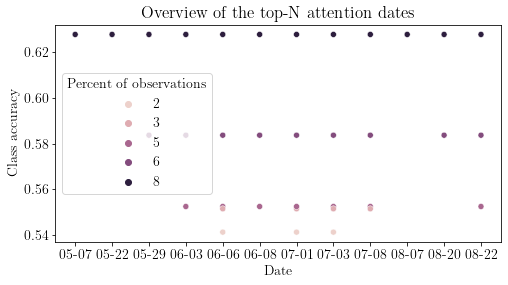

In [40]:
perc_dates_avg_results = perc_dates_results.groupby(["Percent of observations"]).agg("mean").reset_index()
most_important_dates_for_percentage_scores = get_most_important_dates_for_percentage_scores([2, 3, 5, 6, 8], perc_dates_avg_results, avg_attention_per_obs_acq_date_orig_model)
most_important_dates_for_percentage_scores["Percent of observations"] = most_important_dates_for_percentage_scores["Percent of observations"].astype(int)
fig, axs = plt.subplots(figsize=(8, 4))
sns.scatterplot(data=most_important_dates_for_percentage_scores, x="Date", y='Class accuracy', hue="Percent of observations", ax=axs)
#axs.set_title("Overview of the top-N attention dates")

In [17]:
most_important_dates_for_percentage_scores

,Date,Attention,PERCENTAGE,Percent of observations,Class accuracy,F1 Score
20,05-07,3.633729,8,8.0,0.627673,0.656064
32,05-07,3.633729,10,10.0,0.637055,0.666643
19,05-22,3.746568,8,8.0,0.627673,0.656064
31,05-22,3.746568,10,10.0,0.637055,0.666643
29,05-29,4.089293,10,10.0,0.637055,0.666643
17,05-29,4.089293,8,8.0,0.627673,0.656064
8,06-03,4.375712,5,5.0,0.552474,0.573761
27,06-03,4.375712,10,10.0,0.637055,0.666643
15,06-03,4.375712,8,8.0,0.627673,0.656064
2,06-06,6.829939,2,2.0,0.541272,0.568025
